In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/precog-assignment/Judge_Act_merge.csv
/kaggle/input/precog-assignment/judges_clean/judges_clean.csv
/kaggle/input/precog-assignment/acts_sections/acts_sections.csv
/kaggle/input/precog-assignment/cases/cases_2015.csv
/kaggle/input/precog-assignment/cases/cases_2012.csv
/kaggle/input/precog-assignment/cases/cases_2018.csv
/kaggle/input/precog-assignment/cases/cases_2013.csv
/kaggle/input/precog-assignment/cases/cases_2017.csv
/kaggle/input/precog-assignment/cases/cases_2010.csv
/kaggle/input/precog-assignment/cases/cases_2014.csv
/kaggle/input/precog-assignment/cases/cases_2016.csv
/kaggle/input/precog-assignment/cases/cases_2011.csv
/kaggle/input/precog-assignment/keys/type_name_key.csv
/kaggle/input/precog-assignment/keys/cases_district_key.csv
/kaggle/input/precog-assignment/keys/act_key.csv
/kaggle/input/precog-assignment/keys/disp_name_key.csv
/kaggle/input/precog-assignment/keys/purpose_name_key.csv
/kaggle/input/precog-assignment/keys/cases_state_key.csv
/kaggle/inp

In [2]:
import dask.dataframe as dd
from datetime import date
import gc
import glob

In [3]:
ja_df = dd.read_csv("../input/precog-assignment/Judge_Act_merge.csv")
ja_df.head()

,ddl_case_id,ddl_judge_id,act,section,criminal,female_judge
0,01-01-01-201900000022018,5.0,4759.0,1123673.0,1.0,0 nonfemale
1,01-01-01-201900000032017,5.0,4759.0,1123673.0,1.0,0 nonfemale
2,01-01-01-201900000042016,5.0,17353.0,865403.0,1.0,0 nonfemale
3,01-01-01-201900000052018,5.0,4759.0,1123673.0,1.0,0 nonfemale
4,01-01-01-201900000072016,5.0,4759.0,132871.0,1.0,0 nonfemale


In [4]:
case_list = os.path.join("../input/precog-assignment/cases","*.csv")
case_list_csv = glob.glob(case_list)
case_list_csv

['../input/precog-assignment/cases/cases_2015.csv',
 '../input/precog-assignment/cases/cases_2012.csv',
 '../input/precog-assignment/cases/cases_2018.csv',
 '../input/precog-assignment/cases/cases_2013.csv',
 '../input/precog-assignment/cases/cases_2017.csv',
 '../input/precog-assignment/cases/cases_2010.csv',
 '../input/precog-assignment/cases/cases_2014.csv',
 '../input/precog-assignment/cases/cases_2016.csv',
 '../input/precog-assignment/cases/cases_2011.csv']

In [15]:
# case_list_csv = [path for path in case_list_csv if int(path.split("/")[4].split("_")[1].split(".")[0])]
# case_list_csv

In [5]:
def days_elapsed(date1,date2):
    d1s = date1.split("-")
    d2s = date2.split("-")
    d1s = [int(i) for i in d1s]
    d2s = [int(i) for i in d2s]
    d1 = date(d1s[0],d1s[1],d1s[2])
    d2 = date(d2s[0],d2s[1],d2s[2])
    return (d2 - d1).days

In [6]:
overall = {}
male_overall = {}
female_overall = {}
criminal = {}
male_criminal = {}
female_criminal = {}
non_criminal = {}
male_non_criminal = {}
female_non_criminal = {}

female_percentage = {}

In [8]:
for path in case_list_csv:
    
    year_string = int(path.split("/")[4].split("_")[1].split(".")[0])
    
    cases_df = dd.read_csv(path,usecols=["ddl_case_id","date_of_decision","date_of_filing"])
    cases_df = cases_df.dropna(subset=["date_of_decision"]).compute()
    
    merged_df = ja_df.merge(cases_df,how="inner",on=["ddl_case_id"])
    
    g_ratio = (merged_df["female_judge"].value_counts()/len(merged_df)*100)["1 female"]
    female_percentage[year_string] = g_ratio
    
    del cases_df
    gc.collect()
    
    merged_df["time_taken"] = merged_df.apply(lambda x: days_elapsed(x["date_of_filing"],x["date_of_decision"]),axis=1,meta=("days",int))
    merged_df = merged_df.drop(["ddl_case_id","ddl_judge_id","date_of_filing","date_of_decision"],axis=1)
    merged_df = merged_df.astype({"time_taken":"float32"})
    
    grouped_df = (merged_df.groupby(['act','section','female_judge',"criminal"])['time_taken'].mean().reset_index(drop=False))
    
    del merged_df
    gc.collect()
    
    grouped_df = grouped_df.compute() # converting the Dask Datframe to pandas dataframe as the heavy lifing is done
    
    count_df = (grouped_df.groupby(["act","section"]).size().to_frame("size")) ## removed name
    grouped_df = grouped_df.merge(count_df,on=["act","section"],how="inner")
    
    
    
    del count_df
    gc.collect()
    
    grouped_df = grouped_df[grouped_df["size"] == 2]
    grouped_df = grouped_df.drop(["size"],axis=1)
    
    
    
    
    pivot_df = grouped_df.pivot(values="time_taken",index=["act","section","criminal"],columns="female_judge")
    pivot_df = pivot_df.reset_index()
    pivot_df.columns.name = None
    pivot_df = pivot_df.rename(columns={"0 nonfemale":"Male", "1 female":"Female"})
    
    del grouped_df
    gc.collect()
    
    pivot_df["Difference"] = pivot_df.apply(lambda x: x["Female"] - x["Male"],axis=1)
    
    overall[year_string] = pivot_df["Difference"].mean()
    male_overall[year_string] = pivot_df["Male"].mean()
    female_overall[year_string] = pivot_df["Female"].mean()
    
    crime_split_df = (pivot_df.groupby(["criminal"]).agg(Male=("Male","mean"),Female=("Female","mean"),Difference=("Difference","mean")).reset_index(drop=False))
    
    del pivot_df
    gc.collect()
    
    non_criminal[year_string] = crime_split_df.loc[crime_split_df['criminal'] == 0.0, 'Difference'].iloc[0]
    male_non_criminal[year_string] = crime_split_df.loc[crime_split_df['criminal'] == 0.0, 'Male'].iloc[0]
    female_non_criminal[year_string] = crime_split_df.loc[crime_split_df['criminal'] == 0.0, 'Female'].iloc[0]
    
    criminal[year_string] = crime_split_df.loc[crime_split_df['criminal'] == 1.0, 'Difference'].iloc[0]
    male_criminal[year_string] = crime_split_df.loc[crime_split_df['criminal'] == 1.0, 'Male'].iloc[0]
    female_criminal[year_string] = crime_split_df.loc[crime_split_df['criminal'] == 1.0, 'Female'].iloc[0]
    
    del crime_split_df
    gc.collect()
    
    
    

In [9]:
print(overall)
print(criminal)
print(non_criminal)

{2015: 94.90872783808986, 2012: 118.57175318010451, 2018: 7.756532480533502, 2013: 98.6831287073263, 2017: 15.985861873944634, 2010: 211.78007427686907, 2014: 107.13778938897221, 2016: 44.962497062377686, 2011: 62.448828676711166}
{2015: 125.39957905976726, 2012: 128.52122082195, 2018: 15.354627628623657, 2013: 111.41838681240073, 2017: 35.36177893177206, 2010: 209.62754891179026, 2014: 134.81409408255556, 2016: 54.362465564970464, 2011: 60.785940168152095}
{2015: -7.748242868954986, 2012: 33.49659508316476, 2018: -12.27006194759416, 2013: 26.25134823471566, 2017: -32.0247174180771, 2010: 238.78914254821493, 2014: 16.097313423237452, 2016: 14.821707369853492, 2011: 81.88383812049523}


In [24]:
overall = {2015: 94.90872783808986, 2012: 118.57175318010451, 2018: 7.756532480533502, 2013: 98.6831287073263, 2017: 15.985861873944634, 2010: 211.78007427686907, 2014: 107.13778938897221, 2016: 44.962497062377686, 2011: 62.448828676711166}
criminal = {2015: 125.39957905976726, 2012: 128.52122082195, 2018: 15.354627628623657, 2013: 111.41838681240073, 2017: 35.36177893177206, 2010: 209.62754891179026, 2014: 134.81409408255556, 2016: 54.362465564970464, 2011: 60.785940168152095}
non_criminal = {2015: -7.748242868954986, 2012: 33.49659508316476, 2018: -12.27006194759416, 2013: 26.25134823471566, 2017: -32.0247174180771, 2010: 238.78914254821493, 2014: 16.097313423237452, 2016: 14.821707369853492, 2011: 81.88383812049523}

In [35]:
print(female_overall)
print(male_overall)

OrderedDict([(2010, 1817.1932608425889), (2011, 1413.9117874403444), (2012, 1174.1203392221976), (2013, 865.3457554548187), (2014, 584.7686116980748), (2015, 437.99109840240595), (2016, 269.5607111296451), (2017, 139.16165814022304), (2018, 62.74744139310418)])
OrderedDict([(2010, 1605.41318656572), (2011, 1351.462958763633), (2012, 1055.5485860420931), (2013, 766.6626267474924), (2014, 477.63082230910265), (2015, 343.08237056431614), (2016, 224.59821406726743), (2017, 123.17579626627841), (2018, 54.99090891257068)])


In [36]:
female_overall = OrderedDict([(2010, 1817.1932608425889), (2011, 1413.9117874403444), (2012, 1174.1203392221976), (2013, 865.3457554548187), (2014, 584.7686116980748), (2015, 437.99109840240595), (2016, 269.5607111296451), (2017, 139.16165814022304), (2018, 62.74744139310418)])
male_overall = OrderedDict([(2010, 1605.41318656572), (2011, 1351.462958763633), (2012, 1055.5485860420931), (2013, 766.6626267474924), (2014, 477.63082230910265), (2015, 343.08237056431614), (2016, 224.59821406726743), (2017, 123.17579626627841), (2018, 54.99090891257068)])

In [11]:
print(female_criminal)
print(male_criminal)

{2015: 455.1973702532981, 2012: 1178.140027416632, 2018: 73.93555243318761, 2013: 855.5750264645934, 2017: 163.34275711776039, 2010: 1817.4681457039005, 2014: 583.4597030404769, 2016: 276.96612316020406, 2011: 1411.415929113554}
{2015: 329.7977911935308, 2012: 1049.618806594682, 2018: 58.58092480456396, 2013: 744.1566396521927, 2017: 127.98097818598833, 2010: 1607.84059679211, 2014: 448.6456089579214, 2016: 222.6036575952336, 2011: 1350.629988945402}


In [25]:
female_criminal = {2015: 455.1973702532981, 2012: 1178.140027416632, 2018: 73.93555243318761, 2013: 855.5750264645934, 2017: 163.34275711776039, 2010: 1817.4681457039005, 2014: 583.4597030404769, 2016: 276.96612316020406, 2011: 1411.415929113554}
male_criminal = {2015: 329.7977911935308, 2012: 1049.618806594682, 2018: 58.58092480456396, 2013: 744.1566396521927, 2017: 127.98097818598833, 2010: 1607.84059679211, 2014: 448.6456089579214, 2016: 222.6036575952336, 2011: 1350.629988945402}

In [12]:
print(female_non_criminal)
print(male_non_criminal)

{2015: 380.0608119524592, 2012: 1139.7490923422508, 2018: 33.25850267233445, 2013: 920.9167765867256, 2017: 79.2445679522112, 2010: 1813.744110320896, 2014: 589.0742322822783, 2016: 245.8154223514965, 2011: 1443.0821316347053}
{2015: 387.8090548214142, 2012: 1106.2524972590863, 2018: 45.52856461992861, 2013: 894.66542835201, 2017: 111.26928537028832, 2010: 1574.954967772681, 2014: 572.976918859041, 2016: 230.99371498164302, 2011: 1361.1982935142098}


In [26]:
female_non_criminal = {2015: 380.0608119524592, 2012: 1139.7490923422508, 2018: 33.25850267233445, 2013: 920.9167765867256, 2017: 79.2445679522112, 2010: 1813.744110320896, 2014: 589.0742322822783, 2016: 245.8154223514965, 2011: 1443.0821316347053}
male_non_criminal = {2015: 387.8090548214142, 2012: 1106.2524972590863, 2018: 45.52856461992861, 2013: 894.66542835201, 2017: 111.26928537028832, 2010: 1574.954967772681, 2014: 572.976918859041, 2016: 230.99371498164302, 2011: 1361.1982935142098}

In [28]:
import matplotlib.pyplot as plt
from collections import OrderedDict

In [32]:
overall = OrderedDict(sorted(overall.items()))
criminal = OrderedDict(sorted(criminal.items()))
non_criminal = OrderedDict(sorted(non_criminal.items()))
female_overall = OrderedDict(sorted(female_overall.items()))
male_overall = OrderedDict(sorted(male_overall.items()))
female_criminal = OrderedDict(sorted(female_criminal.items()))
male_criminal = OrderedDict(sorted(male_criminal.items()))
female_non_criminal = OrderedDict(sorted(female_non_criminal.items()))
male_non_criminal = OrderedDict(sorted(male_non_criminal.items()))

# **Data Analysis**

Below is the analysis done on the collected data.The purpose of the analysis is to take a step to better understand the reasons for the time taken for the conclusion of a case. Looking at the time_taken by Feamle and Male judges may help us get a slightly better understanding about how the judges operate and in what areas they can be most assisted.

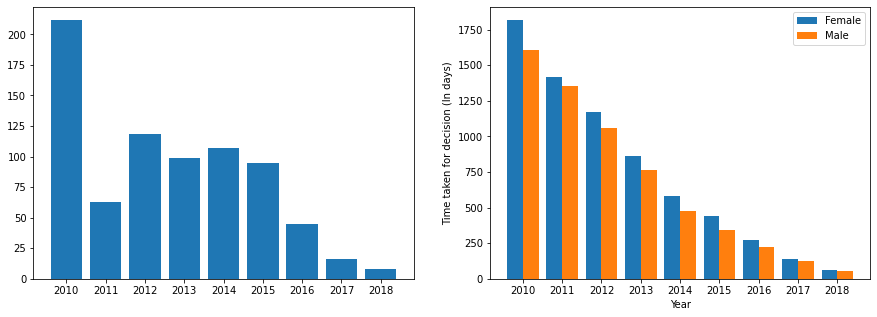

In [57]:
names = list(overall.keys())
values = list(overall.values())

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(overall)), values, tick_label=names)


X = list(male_overall.keys())
valuesM = list(male_overall.values())
valuesF = list(female_overall.values())

X_axis = np.arange(len(overall))


plt.subplot(1, 2, 2)
plt.bar(X_axis - 0.2, valuesF, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, valuesM, 0.4, label = 'Male')
plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("Time taken for decision (In days)")
plt.legend()


plt.show()

**The above graphs shows the following:**

**The graph to the left** shows the difference (in days) of the time taken for a decision to be made, by female judges as compared to male judges. It shows us that on average, female Judges take more time than male judges, though the gap has narrowed with the latest data from 2018 showing the difference being a little under 8 days.

**The graph to the right** shows the average time taken to make a decision by both male and female judges from 2010-2018. The data is encouraging, showing that the average time taken has decreased over this period with the female judges rapidly catching up.

The below graphs shows this data for criminal and non-criminal cases

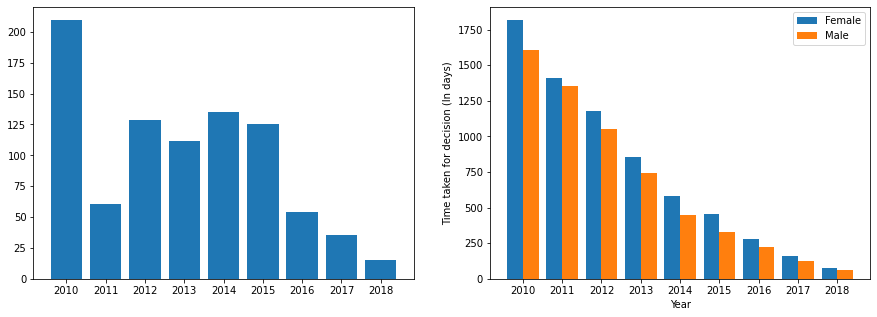

In [58]:
names = list(criminal.keys())
values = list(criminal.values())

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(criminal)), values, tick_label=names)

X = list(overall.keys())
valuesM = list(male_criminal.values())
valuesF = list(female_criminal.values())

X_axis = np.arange(len(overall))

plt.subplot(1, 2, 2)
plt.bar(X_axis - 0.2, valuesF, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, valuesM, 0.4, label = 'Male')
plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("Time taken for decision (In days)")
plt.legend()
plt.show()

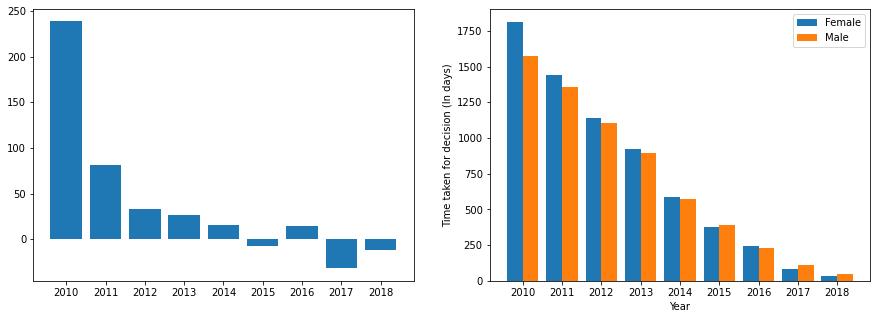

In [59]:
names = list(non_criminal.keys())
values = list(non_criminal.values())

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(non_criminal)), values, tick_label=names)

X = list(male_overall.keys())
valuesM = list(male_non_criminal.values())
valuesF = list(female_non_criminal.values())

X_axis = np.arange(len(overall))

plt.subplot(1, 2, 2)
plt.bar(X_axis - 0.2, valuesF, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, valuesM, 0.4, label = 'Male')
plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("Time taken for decision (In days)")
plt.legend()
plt.show()

**Criminal and Non-Criminal Case Data**

As we can see the criminal cases show a similar trend to the overall cases, with the general trend of the difference in time taken between male and female judges decreasing over the time period from 2010-2018, with the most recent data showing that feamle judges take 15 days more to come to a decision as compared to male judges in criminal cases. 

In the non-criminal cases, female judges have in fact seemed to progress more rapidly and in fact the latest data shows us that female judges now take 12 days less on average to come to a decision on non-criminal cases. 

# Insight

From the above data we can gleam the following:

**1. Criminal Cases are more frequently dealt with and take more time on average to conclude, and hence any Legal AI system built to augment the judicial process will be more valued in criminal cases**

**2. Female judges have rapidly caught up with Male judges in terms of the time taken to decide cases, and in fact are seen to decide non-crminal cases more quickly than male judges. This may show that Male judges in particular may need some help in deciding non-criminal cases, and may be more benefitted by a Legal AI system in these cases. Also, understanding the deeper reasons behind why female judges are dealing woth non-crminal cases more quickly could help in the building of such an AI system** 
